In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils import load_tweets, process_tweet

%matplotlib inline

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...


In [3]:
import w1_unittest

In [4]:
all_positive_tweets, all_negative_tweets = load_tweets()

print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [6]:
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]

In [8]:
# Split positive set into validation and training
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]
# Split negative set into validation and training
val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg 
val_x  = val_pos + val_neg

# Set the labels for the training and validation set (1 for positive, 0 for negative)
train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


In [9]:
def build_vocabulary(corpus):

    vocab = {'': 0, '[UNK]': 1} 

    for tweet in corpus:
        
        for word in tweet:
            
            if word not in vocab:
                vocab[word] = len(vocab)
    
    
    return vocab


vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9535 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4, 'member': 5, 'community': 6, 'week': 7, ':)': 8, 'hey': 9, 'james': 10, 'odd': 11, ':/': 12, 'please': 13, 'call': 14, 'contact': 15, 'centre': 16, '02392441234': 17, 'able': 18, 'assist': 19, 'many': 20, 'thanks': 21, 'listen': 22, 'last': 23, 'night': 24, 'bleed': 25, 'amazing': 26, 'track': 27, 'scotland': 28, 'congrats': 29, 'yeaaah': 30, 'yipppy': 31, 'accnt': 32, 'verify': 33, 'rqst': 34, 'succeed': 35, 'get': 36, 'blue': 37, 'tick': 38, 'mark': 39, 'fb': 40, 'profile': 41, '15': 42, 'day': 43, 'one': 44, 'irresistible': 45, 'flipkartfashionfriday': 46, 'like': 47, 'keep': 48, 'lovely': 49, 'customer': 50, 'wait': 51, 'long': 52, 'hope': 53, 'enjoy': 54, 'happy': 55, 'friday': 56, 'lwwf': 57, 'second': 58, 'thought': 59, '’': 60, 'enough': 61, 'time': 62, 'dd': 63, 'new': 64, 'short': 65, 'enter': 66, 'system': 67, 'sheep': 68, 'must': 69, 'buy': 70, 'jgh': 71, 'go': 72, 'bayan': 73, ':D

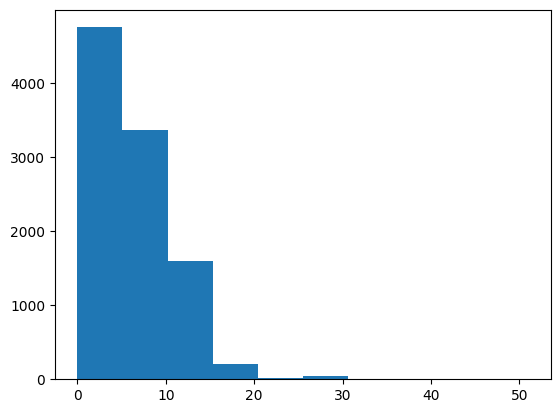

In [11]:
# Tweet lengths
plt.hist([len(t) for t in train_x + val_x]);

In [12]:
def max_length(training_x, validation_x):
   
    max_len = 0

    for tweet in training_x+validation_x:
        tweet_len = len(tweet )
        if tweet_len > max_len:
            max_len = tweet_len
    return max_len

max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [14]:
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    unk_ID = vocab_dict[unk_token] 

    tweet_ids = [vocab_dict[word] if word in vocab_dict else unk_ID for word in tweet]

    padded_tensor = tweet_ids + [0] * (max_len - len(tweet_ids))

    return padded_tensor

In [16]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

In [17]:
def relu(x):
   
    activation = np.maximum(x,0)
    
    return activation

In [20]:
def sigmoid(x):

    activation = 1/(1+np.exp(-x))

    return activation    

In [26]:
class Dense():
  
    def __init__(self, n_units, input_shape, activation, stdev=0.1, random_seed=42):

        self.n_units = n_units
        self.random_generator = np.random.default_rng(seed=random_seed)
        self.activation = activation

        input_size = input_shape[1]
        w = self.random_generator.normal(scale=stdev, size = (input_size, n_units))

        self.weights = w
        

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):

        dense = np.dot(x,self.weights)

        dense = self.activation(dense)

        return dense

In [30]:
def create_model(num_words, embedding_dim, max_len):

    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [31]:

model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)


The model is created!



In [33]:
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20
250/250 [==============================] - 16s 52ms/step - loss: 0.6823 - accuracy: 0.6506 - val_loss: 0.6656 - val_accuracy: 0.9915
Epoch 2/20
250/250 [==============================] - 3s 13ms/step - loss: 0.6305 - accuracy: 0.9555 - val_loss: 0.5954 - val_accuracy: 0.9775
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.5379 - accuracy: 0.9869 - val_loss: 0.4968 - val_accuracy: 0.9900
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4310 - accuracy: 0.9896 - val_loss: 0.3959 - val_accuracy: 0.9930
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.3339 - accuracy: 0.9940 - val_loss: 0.3097 - val_accuracy: 0.9915
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2557 - accuracy: 0.9942 - val_loss: 0.2425 - val_accuracy: 0.9960
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.1964 - accuracy: 0.9954

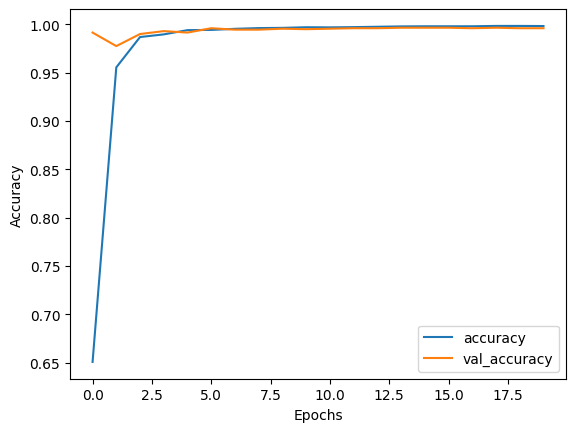

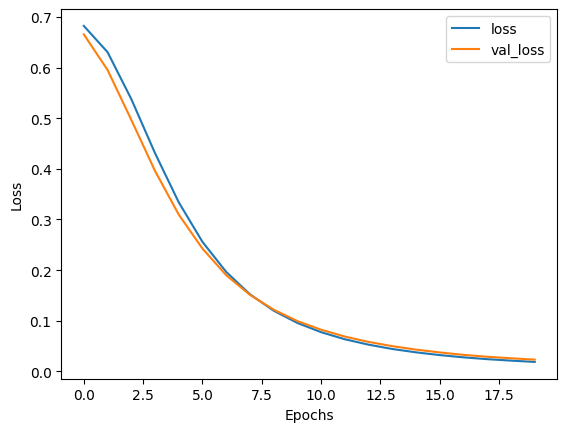

In [34]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [35]:

example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

model.predict(example_for_prediction)

1/1 [==============================] - 0s 63ms/step


array([[0.888332  ],
       [0.9942756 ],
       [0.99696785],
       [0.9502717 ],
       [0.99764097],
       [0.99616927],
       [0.9919835 ],
       [0.9794622 ],
       [0.99842525],
       [0.9983078 ],
       [0.01064505],
       [0.04169211],
       [0.01273234],
       [0.01671799],
       [0.01775521],
       [0.00633166],
       [0.01639779],
       [0.00801933],
       [0.02289547],
       [0.03114719]], dtype=float32)

In [36]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)
    
    return prediction[0][0]

In [37]:
unseen_tweet = '@DLAI @NLP_team_dlai OMG!!! what a daaay, wow, wow. This AsSiGnMeNt was gr8.'

prediction_unseen = get_prediction_from_tweet(unseen_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction_unseen}")

Model prediction on unseen tweet: 0.7512750625610352


In [87]:

embeddings_layer = model.layers[0]

embeddings = embeddings_layer.get_weights()[0]

print(f"Weights of embedding layer have shape: {embeddings.shape}")

Weights of embedding layer have shape: (9535, 16)


In [88]:
pca = PCA(n_components=2)

embeddings_2D = pca.fit_transform(embeddings)

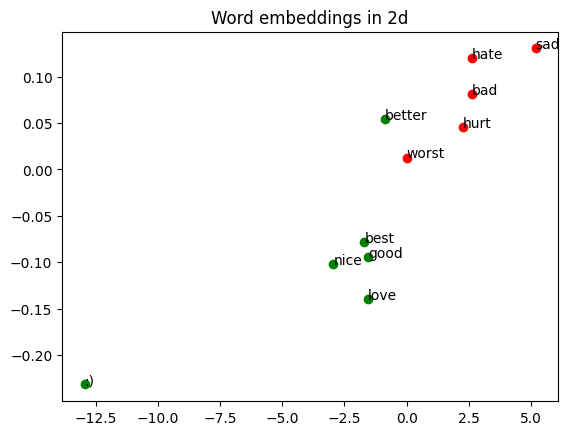

In [89]:
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()